## We will be using the final ensemble of simple classifier and segmentation classifier networks for inference. Users can supply their own images as a URL, and the script will produce image examples of the top 3 predictions by the network.

### Install the required packages

In [3]:
# Install required packages
from distutils.dir_util import copy_tree
copy_tree("D:/Capstone Project/results/lib", "D:/Capstone Project/Working/")
!pip install efficientnet_pytorch

import os
import csv
import albumentations as A
from glob import glob
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import sys
sys.path.append("D:/Capstone Project/results/lib")

import torch
from torch.utils.data import DataLoader

In [4]:
from data import CLASSES, format_prosthesis_name
from metrics import print_metrics
from plots import plot_confusion_matrix
from datasets import OrthonetClassificationDataset
from models import get_unet, CLASSIFIER_MODEL_GENERATORS
from training import load_classifier_transforms
from testing import eval_seg, eval_unetseg, eval_ensemble, write_predictions_to_csv

In [5]:
# Paths
CSV_TEST = "D:/Capstone Project/archive/test.csv"
MODEL_DIR = "D:/Capstone Project/Orthonet_Models"
DATA_PATH = "D:/Capstone Project/archive/orthonet data/orthonet data new"

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BS_TEST = 8
N_WORKERS = 2

In [6]:
_, test_transforms = load_classifier_transforms()
ds_test = OrthonetClassificationDataset('test', CSV_TEST, DATA_PATH, test_transforms)
dl_test = DataLoader(ds_test, BS_TEST, shuffle=False, num_workers=N_WORKERS, pin_memory=True)

ds_test.stats()

class_names = [format_prosthesis_name(c) for c in CLASSES]

Found 180 test samples from D:/Capstone Project/archive/test.csv

156 unique patients
Class                                             Number of samples
Knee_SmithAndNephew_Legion2                       15
Hip_JRIOrtho_FurlongEvolution_NilCol              15
Hip_DepuySynthes_Corail_NilCol                    15
Hip_Stryker_Exeter                                15
Knee_ZimmerBiomet_Oxford                          15
Knee_Depuy_Synthes_Sigma                          15
Hip_SmithAndNephew_Polarstem_NilCol               15
Knee_SmithAndNephew_GenesisII                     15
Hip_DepuySynthes_Corail_Collar                    15
Hip_JRIOrtho_FurlongEvolution_Collar              15
Hip_Stryker_AccoladeII                            15
Hip_SmithAndNephew_Anthology                      15




## Simple Classifier
It uses simple CNN with a single (grayscale) color channel to classify X-rays.7 different architectures of neural network are assessed.

--- Efficientnet ---
Accu:	0.9778
Prec:	0.9798
Rec:	0.9778
F1:	0.9777
Top3:	0.9889



--- Resnet50 ---
Accu:	0.9389
Prec:	0.9429
Rec:	0.9389
F1:	0.9376
Top3:	0.9778



--- Inceptionv3 ---
Accu:	0.9667
Prec:	0.9740
Rec:	0.9667
F1:	0.9675
Top3:	1.0000



--- Densenet121 ---
Accu:	0.9722
Prec:	0.9740
Rec:	0.9722
F1:	0.9718
Top3:	0.9944



--- Mobilenetv3 ---
Accu:	0.9000
Prec:	0.9095
Rec:	0.9000
F1:	0.8984
Top3:	0.9778



--- Resnext50 ---
Accu:	0.9556
Prec:	0.9584
Rec:	0.9556
F1:	0.9546
Top3:	0.9722



--- Wideresnet50 ---
Accu:	0.9667
Prec:	0.9700
Rec:	0.9667
F1:	0.9663
Top3:	0.9944





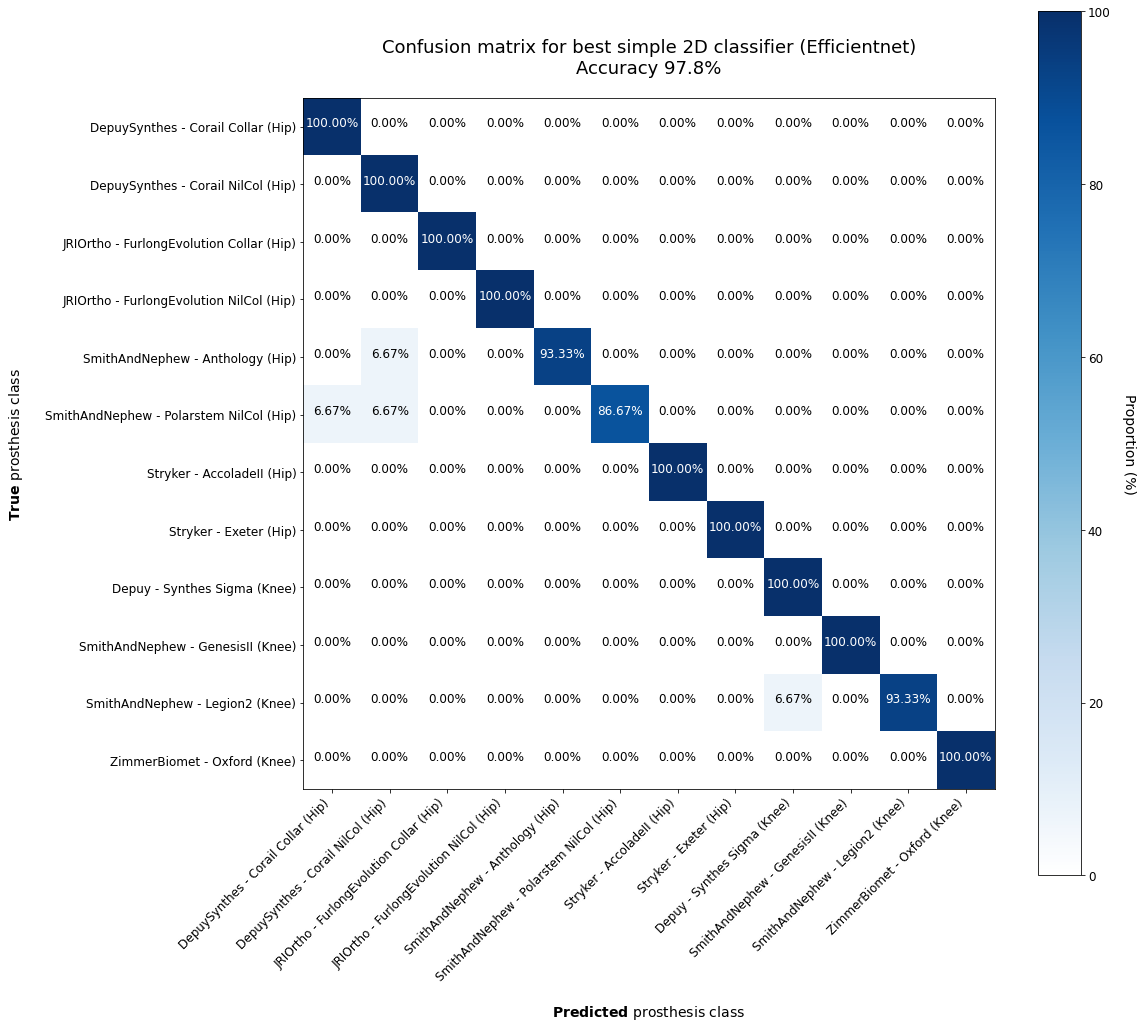

In [7]:
results_by_model_2d = {}
best_2d_model = (0, None, None)  # Will store accuracy, model_type and the path to the weights

for model_type, model_generator in CLASSIFIER_MODEL_GENERATORS.items():
    
    model_paths = glob(os.path.join(MODEL_DIR, f"{model_type}*.pt"))
    if len(model_paths) == 0:
        continue
    
    mdl = model_generator(n_in=1, n_out=len(CLASSES)).to(DEVICE)
    assert len(model_paths) == 1, f"Expected to find 1 {model_type} models, but found {len(model_paths)}"
    mdl.load_state_dict(torch.load(model_paths[0], map_location ='cpu')['state_dict'])
    
    results_2d = eval_seg(mdl, dl_test, DEVICE)
    results_by_model_2d[model_type] = results_2d

    print_metrics(results_2d, model_type.title())
    write_predictions_to_csv(results_2d, f"results_2d_{model_type}.csv")

    acc = accuracy_score(results_2d['y_true'], results_2d['y_pred'])
    if acc > best_2d_model[0]:
        best_2d_model = acc, model_type, model_paths[0]

best_acc_2d, best_model_type_2d, _best_model_path_2d = best_2d_model
cm = confusion_matrix(results_by_model_2d[best_model_type_2d]['y_true'], results_by_model_2d[best_model_type_2d]['y_pred'])
plot_confusion_matrix(cm, class_names, f"Confusion matrix for best simple 2D classifier ({best_model_type_2d.title()})\n"
                                       f"Accuracy {best_acc_2d*100:.1f}%")

## Ensemble of simple classifiers

--- Ensemble of 7 simple classifiers ---
Accu:	0.9778
Prec:	0.9792
Rec:	0.9778
F1:	0.9775
Top3:	0.9889





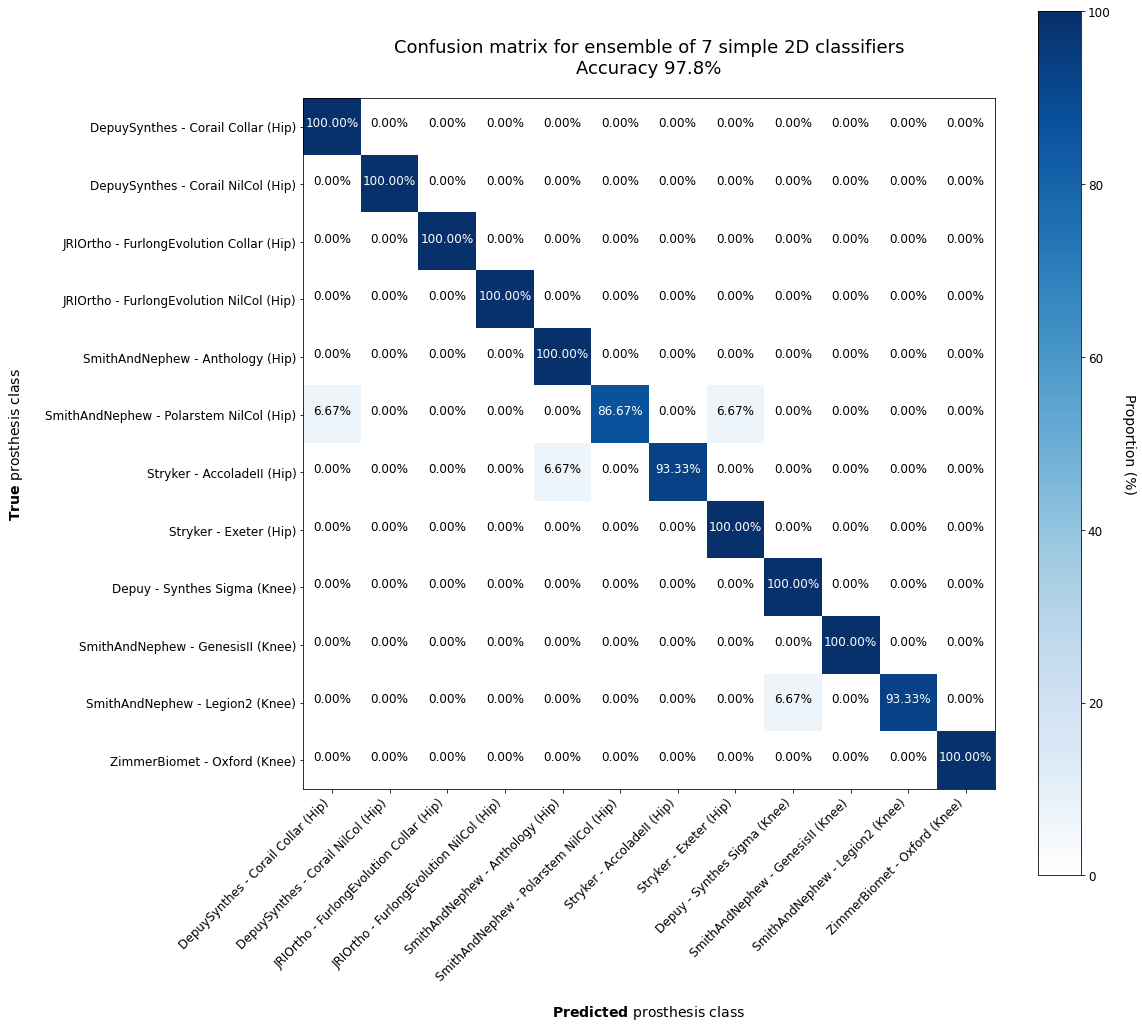

In [8]:
mdls = []

for model_type, model_generator in CLASSIFIER_MODEL_GENERATORS.items():
    
    model_paths = glob(os.path.join(MODEL_DIR, f"{model_type}*.pt"))
    if len(model_paths) == 0:
        continue
    
    mdl = model_generator(n_in=1, n_out=len(CLASSES)).to(DEVICE)
    assert len(model_paths) == 1, f"Expected to find 1 {model_type} models, but found {len(model_paths)}"
    mdl.load_state_dict(torch.load(model_paths[0],map_location ='cpu')['state_dict'])
    
    mdls.append(mdl)
    
results_2d_ensemble = eval_seg(mdls, dl_test, DEVICE)

print_metrics(results_2d_ensemble, f"Ensemble of {len(mdls)} simple classifiers")
write_predictions_to_csv(results_2d_ensemble, "results_ensemble_2d.csv")

for mdl in mdls:
    del mdl
del mdls
torch.cuda.empty_cache()

acc_2d_ensemble = accuracy_score(results_2d_ensemble['y_true'], results_2d_ensemble['y_pred'])
cm = confusion_matrix(results_2d_ensemble['y_true'], results_2d_ensemble['y_pred'])
plot_confusion_matrix(cm, class_names, f"Confusion matrix for ensemble of {len(CLASSIFIER_MODEL_GENERATORS)} simple 2D classifiers\n"
                                       f"Accuracy {acc_2d_ensemble*100:.1f}%")

## Segmented image classifier

--- Efficientnet ---
Accu:	0.9722
Prec:	0.9732
Rec:	0.9722
F1:	0.9720
Top3:	0.9944



--- Resnet50 ---
Accu:	0.9667
Prec:	0.9694
Rec:	0.9667
F1:	0.9664
Top3:	1.0000



--- Inceptionv3 ---
Accu:	0.9556
Prec:	0.9615
Rec:	0.9556
F1:	0.9552
Top3:	0.9833



--- Densenet121 ---
Accu:	0.9667
Prec:	0.9700
Rec:	0.9667
F1:	0.9663
Top3:	1.0000



--- Mobilenetv3 ---
Accu:	0.9444
Prec:	0.9455
Rec:	0.9444
F1:	0.9433
Top3:	1.0000



--- Resnext50 ---
Accu:	0.9778
Prec:	0.9788
Rec:	0.9778
F1:	0.9778
Top3:	0.9944



--- Wideresnet50 ---
Accu:	0.9722
Prec:	0.9733
Rec:	0.9722
F1:	0.9720
Top3:	1.0000





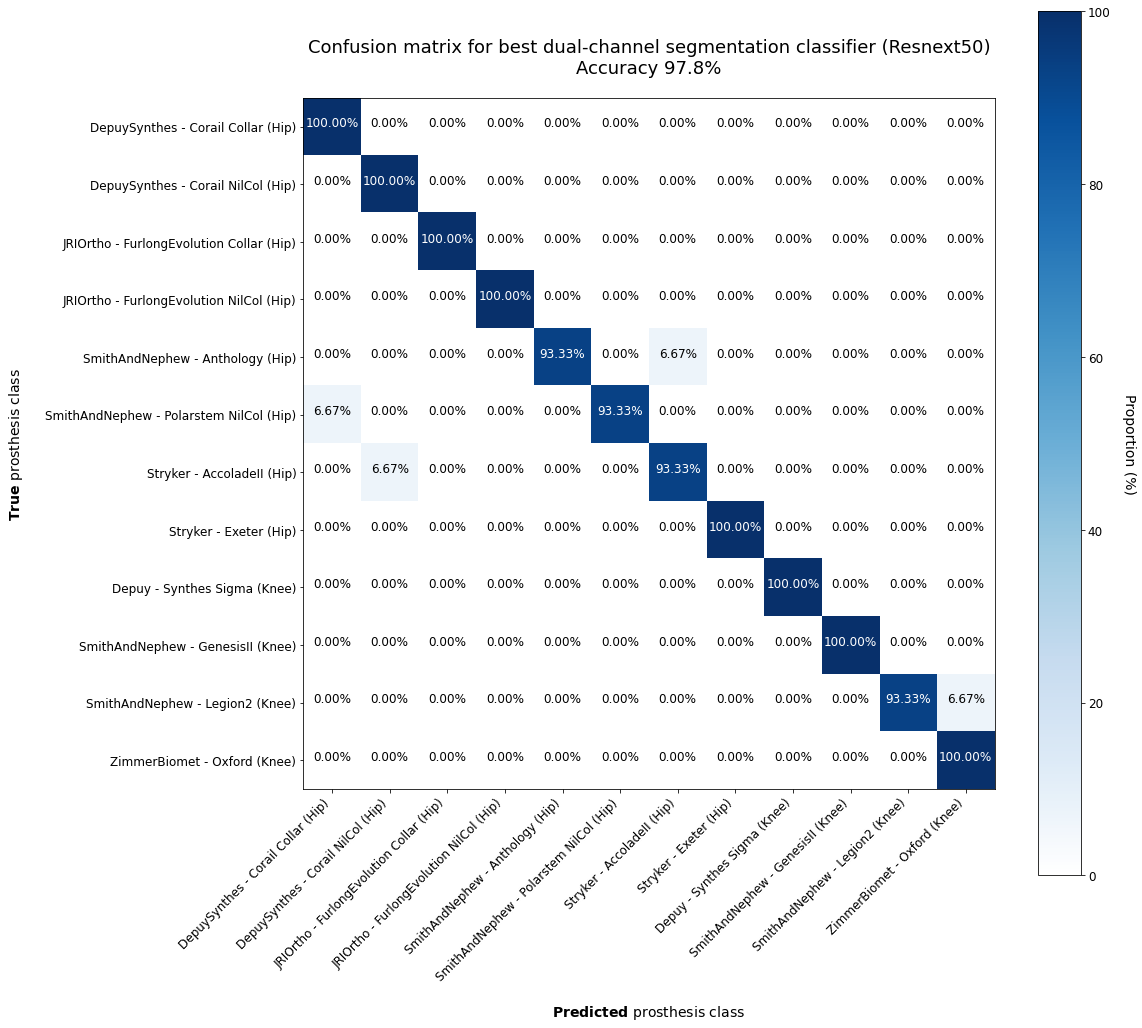

In [9]:
unet_paths = glob(os.path.join(MODEL_DIR, "seg_unet_*.pt"))
assert len(unet_paths) == 1, f"Expected 1 set of unet weights in {MODEL_DIR} but found {unet_paths}"
unet_path = unet_paths[-1]

unet_model = get_unet(1, 1)
unet_model.load_state_dict(torch.load(unet_path,map_location ='cpu')['state_dict'])
unet_model = unet_model.to(DEVICE)

clahe_transform = A.Compose([A.CLAHE(p=1)])

mdls = []

results_by_model_seg = {}

best_seg_model = (0, None, None)

for model_type, model_generator in CLASSIFIER_MODEL_GENERATORS.items():
    model_paths = glob(os.path.join(MODEL_DIR, f"segclass_s_{model_type}*.pt"))

    if len(model_paths) == 0:
        print(f"No models found for {model_type}")
        continue
    assert len(model_paths) == 1, f"Expected to find 1 {model_type} models, but found {len(model_paths)}"

    mdl = model_generator(n_in=2, n_out=len(CLASSES)).to(DEVICE)
    mdl.load_state_dict(torch.load(model_paths[0] ,map_location ='cpu')['state_dict'])

    mdls.append(mdl)

    results_unetseg = eval_unetseg(mdl, unet_model, dl_test, True, DEVICE, clahe_transform=clahe_transform)
    results_by_model_seg[model_type] = results_unetseg

    print_metrics(results_unetseg, model_type.title())

    write_predictions_to_csv(results_unetseg, f"results_unetseg_{model_type}.csv")

    acc = accuracy_score(results_unetseg['y_true'], results_unetseg['y_pred'])
    if acc > best_seg_model[0]:
        best_seg_model = acc, model_type, model_paths[0]

for mdl in mdls:
    del mdl
del mdls
torch.cuda.empty_cache()

best_acc, best_model_type, _best_model_path = best_seg_model
cm = confusion_matrix(results_by_model_seg[best_model_type]['y_true'], results_by_model_seg[best_model_type]['y_pred'])
plot_confusion_matrix(cm, class_names, f"Confusion matrix for best dual-channel segmentation classifier ({best_model_type.title()})\n"
                                       f"Accuracy {best_acc*100:.1f}%")

## Ensemble stacked
Finally, we ensemble the best performing simple classifier and the best performing segmentation classifier (both of the EfficientNet architecture).

--- Ensemble of simple Efficientnet classifier and Resnext50 ---
Accu:	0.9889
Prec:	0.9896
Rec:	0.9889
F1:	0.9887
Top3:	0.9944





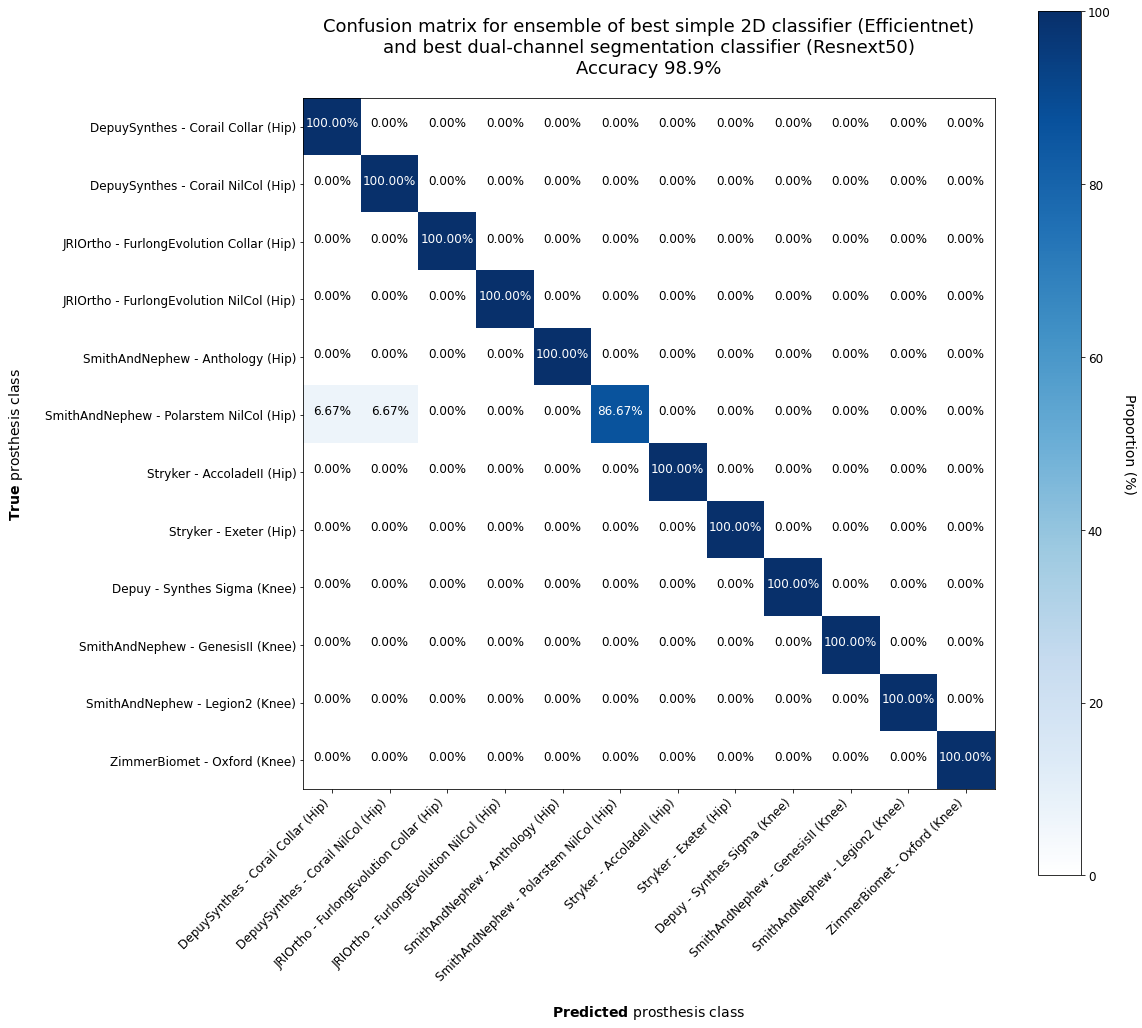

In [11]:
_, model_2d_type, model_2d_path = best_2d_model
model_2d = CLASSIFIER_MODEL_GENERATORS[model_2d_type](n_in=1, n_out=len(CLASSES)).to(DEVICE)
model_2d.load_state_dict(torch.load(model_2d_path,map_location ='cpu')['state_dict'])

model_seg_acc, model_seg_type, model_seg_path = best_seg_model
model_seg = CLASSIFIER_MODEL_GENERATORS[model_seg_type](n_in=2, n_out=len(CLASSES)).to(DEVICE)
model_seg.load_state_dict(torch.load(model_seg_path,map_location ='cpu')['state_dict'])

results_ensemble_seg =  eval_ensemble(model_2d, unet_model, model_seg, dl_test, True, DEVICE, ensemble_weight=1, clahe_transform=clahe_transform)

print_metrics(results_ensemble_seg, f"Ensemble of simple {model_2d_type.title()} classifier and {model_seg_type.title()}")

write_predictions_to_csv(results_ensemble_seg, f"results_ensemble_seg_{model_2d_type}_{model_seg_type}.csv")

acc_ensemble_seg = accuracy_score(results_ensemble_seg['y_true'], results_ensemble_seg['y_pred'])
cm = confusion_matrix(results_ensemble_seg['y_true'], results_ensemble_seg['y_pred'])
plot_confusion_matrix(cm, class_names, f"Confusion matrix for ensemble of best simple 2D classifier ({model_2d_type.title()})\n"
                                       f"and best dual-channel segmentation classifier ({model_seg_type.title()})\n"
                                       f"Accuracy {acc_ensemble_seg*100:.1f}%")

## Perform Inference

In [27]:
import numpy as np
import matplotlib.pyplot as plt

from urllib.request import urlopen
from PIL import Image

# Web link to the radiograph
PATH_RADIOGRAPH = "D:/Capstone Project/archive/orthonet data/orthonet data new/0014_11_13_R0005_UNIL.png"

# Load the models
# Simple classifier
_, model_2d_type, model_2d_path = best_2d_model
model_2d = CLASSIFIER_MODEL_GENERATORS[model_2d_type](n_in=1, n_out=len(CLASSES)).to(DEVICE)
model_2d.load_state_dict(torch.load(model_2d_path,map_location ='cpu')['state_dict'])
model_2d.eval()

# UNET
unet_paths = glob(os.path.join(MODEL_DIR, "seg_unet_*.pt"))
assert len(unet_paths) == 1, f"Expected 1 set of unet weights in {MODEL_DIR} but found {unet_paths}"
unet_path = unet_paths[-1]
unet_model = get_unet(1, 1).to(DEVICE)
unet_model.load_state_dict(torch.load(unet_path,map_location ='cpu')['state_dict'])
unet_model = unet_model.eval()
clahe_transform = A.Compose([A.CLAHE(p=1)])

# Segmentation classifier
_, model_seg_type, model_seg_path = best_seg_model
model_seg = CLASSIFIER_MODEL_GENERATORS[model_seg_type](n_in=2, n_out=len(CLASSES)).to(DEVICE)
model_seg.load_state_dict(torch.load(model_seg_path,map_location ='cpu')['state_dict'])
model_seg.to(DEVICE).eval()

# Load the image
for img in PATH_RADIOGRAPH:
    if PATH_RADIOGRAPH.startswith("https"):
        img = np.array(Image.open(urlopen(PATH_RADIOGRAPH)))
    else:
        img = np.array(Image.open(PATH_RADIOGRAPH))
        
# Process image to pass into network
x = test_transforms(image=img)['image'] / 255.
x = torch.from_numpy(x).float().unsqueeze_(0).unsqueeze_(0).to(DEVICE)

with torch.no_grad():
    # Simple classifier
    y_pred_classifier = model_2d(x)
    
    # Unet model & prep input for seg classifier
    mask = torch.sigmoid(unet_model(x)) > 0.5
    x_m = x.clone()
    x_m[~mask] = 0
    x = torch.cat((x_m, x), dim=1)
    
    # Contrast-limited adaptive histogram equalisation
    x[0,0] = torch.tensor(clahe_transform(image=(x[0,0].cpu().numpy() * 255).astype(np.uint8))['image']/255).float()
                  
    # Seg classifier
    y_pred_segclassifier = model_seg(x)
    
    # Ensemble
    ensemble_weight = 1
    y_pred = ((torch.softmax(y_pred_segclassifier, dim=1)*ensemble_weight + torch.softmax(y_pred_classifier, dim=1)) / (1+ensemble_weight)).cpu().numpy()

top_3_classes = y_pred[0].argsort()[-3:][::-1]
top_3_confidences = y_pred[0][top_3_classes]

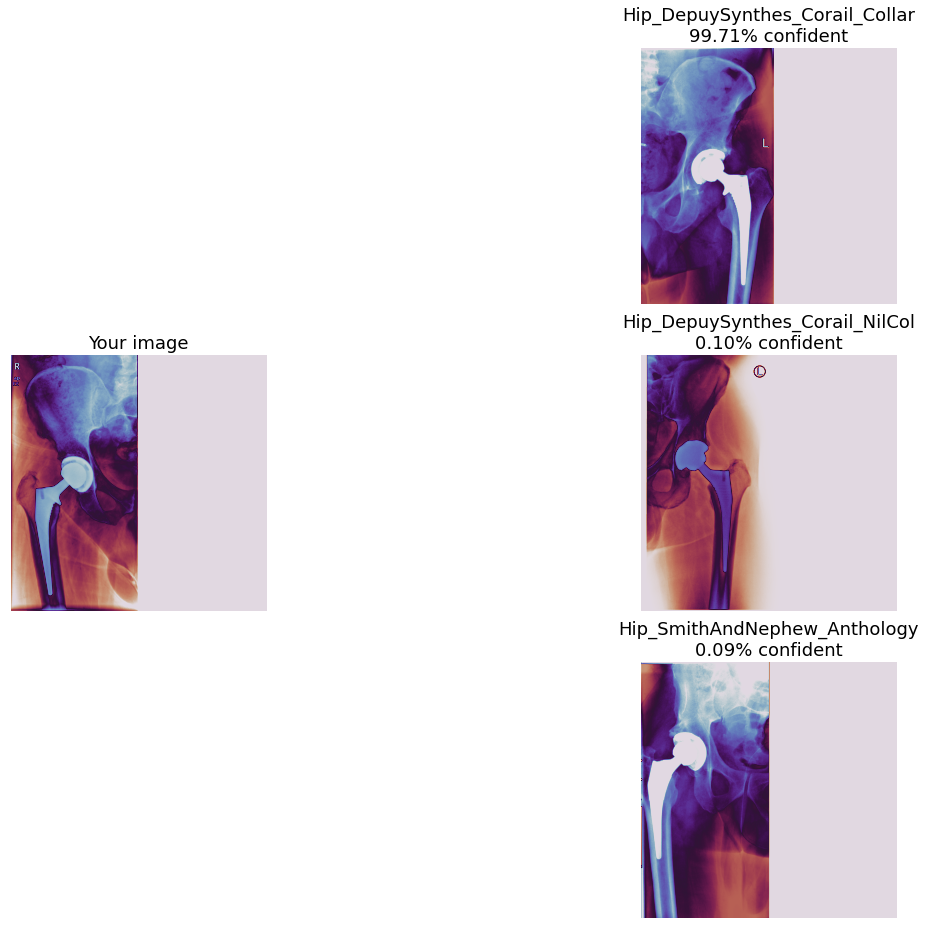

In [28]:
import skimage.io

# Build up an array of example images
example_images = {}
for sample in ds_test.samples:
    example_images[sample['labels']] = sample['filenames']

fig, axes = plt.subplots(3,3,figsize=(16,16))


for r in axes:
    for c in r:
        c.axis('off')

axes[1,0].imshow(img, cmap='twilight_r')
axes[1,0].set_title("Your image")
axes[1,0].axis('off')

class0_path = os.path.join(DATA_PATH, example_images[CLASSES[top_3_classes[0]]])
axes[0,2].imshow(skimage.io.imread(class0_path), cmap='twilight_r')
axes[0,2].set_title(f"{CLASSES[top_3_classes[0]]}\n{top_3_confidences[0]*100:.2f}% confident")

class1_path = os.path.join(DATA_PATH, example_images[CLASSES[top_3_classes[1]]])
axes[1,2].imshow(skimage.io.imread(class1_path), cmap='twilight_r')
axes[1,2].set_title(f"{CLASSES[top_3_classes[1]]}\n{top_3_confidences[1]*100:.2f}% confident")

class2_path = os.path.join(DATA_PATH, example_images[CLASSES[top_3_classes[2]]])
axes[2,2].imshow(skimage.io.imread(class2_path), cmap='twilight_r')
axes[2,2].set_title(f"{CLASSES[top_3_classes[2]]}\n{top_3_confidences[2]*100:.2f}% confident")

plt.show()